## スペクトル分解

実数を成分とする対称行列（エルミート行列）はスペクトル分解という形で固有値と固有ベクトルにもとづいて分解することができる。

この記事ではスペクトル分解の概要とPythonにおける実装について説明する。

スペクトル分解に似た行列分解の手法に特異値分解がある。特異値分解は、推薦システムにおいてよく使用されるスペクトル分解の一形態である。

推薦システムで利用される特異値分解と低ランク近似については以下の記事に書いたので、時間があるときに参考にしていただきたい。

http://wayama.io/rec/linalg/base/


## ソースコード

### github
- jupyter notebook形式のファイルは[こちら](https://github.com/hiroshi0530/wa-src/blob/master/rec/linalg/06/06_nb.ipynb)

### google colaboratory
- google colaboratory で実行する場合は[こちら](https://colab.research.google.com/github/hiroshi0530/wa-src/blob/master/rec/linalg/06/06_nb.ipynb)


## 実行環境
OSはmacOSである。LinuxやUnixのコマンドとはオプションが異なりますので注意していただきたい。

In [1]:
!sw_vers

ProductName:		macOS
ProductVersion:		13.5.1
BuildVersion:		22G90


In [2]:
!python -V

Python 3.9.17


pandasのテーブルを見やすいようにHTMLのテーブルにCSSの設定を行う。

In [ ]:
from IPython.core.display import HTML

style = """
<style>
    .dataframe thead tr:only-child th {
        text-align: right;
    }

    .dataframe thead th {
        text-align: left;
        padding: 5px;
    }

    .dataframe tbody tr th {
        vertical-align: top;
        padding: 5px;
    }

    .dataframe tbody tr:hover {
        background-color: #ffff99;
    }

    .dataframe {
        background-color: white;
        color: black;
        font-size: 16px;
    }

</style>
"""
HTML(style)

基本的なライブラリをインポートし watermark を利用してそのバージョンを確認する。
ついでにrandomとnumpyのseedの設定を行う。

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [6]:
import random

import scipy
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import networkx as nx

import array_to_latex as a2l

seed = 123
random_state = 123

random.seed(seed)
np.random.seed(seed)


from watermark import watermark

print(watermark(python=True, watermark=True, iversions=True, globals_=globals()))

Python implementation: CPython
Python version       : 3.9.17
IPython version      : 8.17.2

numpy         : 1.25.2
array_to_latex: 0.91
matplotlib    : 3.8.1
networkx      : 3.1
scipy         : 1.11.2

Watermark: 2.4.3



## スペクトル分解の概要

最初に簡単な対称行列の性質をおさらいする。

実数を成分とする対称行列を $\displaystyle \mathbf{A} = \left(a_{ij}\right) \in \mathbb{R}^{n\times n}$とする。対称行列なので、$\mathbf{A} = \mathbf{A^T}$である。この行列の固有値はすべて実数である。固有値を$\alpha_1, \alpha_2, \cdots, \alpha_n$とすると、小さい方から順に以下のように定義できる。

$$
\begin{equation}
\alpha_1 \leqq \alpha_2 \leqq \ldots \leqq \alpha_n
\end{equation}
$$

各固有値に対応する固有ベクトルを$\mathbf{v_1} , \mathbf{v_2}, \cdots,  \mathbf{v_n}$とすると、

$$
\begin{equation}
\mathbf{A} \mathbf{x}_i=\alpha_i \mathbf{x}_i \quad(i=1,2, \ldots, n)
\end{equation}
$$

が成立する。

また、エルミート行列（実数の場合は対称行列）の固有ベクトルは、そのベクトル空間における正規直交基底を形成する。

$$
\begin{equation}
\mathbf{x}_i^T \mathbf{x}_j=\delta _{i j}
\end{equation}
$$

よって、

$$
\begin{equation}
\mathbf{A}\left(\begin{array}{llll}
\mathbf{v_1} & \mathbf{v_2} & \cdots & \mathbf{v_n}
\end{array}\right)=\left(\begin{array}{llll}
\mathbf{v_1} & \mathbf{v_2} & \cdots & \mathbf{v_n}
\end{array}\right)\left(\begin{array}{cccc}
\alpha_1 & 0 & \cdots & 0 \\
0 & \alpha_2 & \cdots & 0 \\
\vdots & \vdots & \ddots & \vdots \\
0 & 0 & \cdots & \alpha_n
\end{array}\right)
\end{equation}
$$

が成立する。ここで、$\mathbf{V}$を

$$
\mathbf{V}=\left(\begin{array}{llll}
\mathbf{v_1} & \mathbf{v_2} & \cdots & \mathbf{v_n}
\end{array}\right)
$$

と定義すると、$\mathbf{V}^T\mathbf{V}=\mathbf{I}$で、$\mathbf{V}^T=\mathbf{V}^{-1}$となるので、$\mathbf{V}\mathbf{V}^{T}=\mathbf{I}$も成立する。

よって、

$$
\begin{equation}
\mathbf{A}=\left(\begin{array}{llll}
\mathbf{v}_1 & \mathbf{v}_2 & \cdots & \mathbf{v}_n
\end{array}\right)\left(\begin{array}{cccc}
\alpha_1 & 0 & \cdots & 0 \\
0 & \alpha_2 & \cdots & 0 \\
\vdots & \vdots & \ddots & \vdots \\
0 & 0 & \cdots & \alpha_n
\end{array}\right)\left(\begin{array}{c}
\mathbf{v}_1^T \\
\mathbf{v}_2^T \\
\vdots \\
\mathbf{v}_n^T
\end{array}\right)
\end{equation}
$$

と書ける。これを各固有値に注目し計算すると以下のように和の形に分解できる。

$$
\begin{equation}
\mathbf{A}=\alpha_1 \mathbf{v}_1 \mathbf{v}_1^T+\alpha_2 \mathbf{v}_2 \mathbf{v}_2^T+\cdots+\alpha_n \mathbf{v}_n \mathbf{v}_n^T
\end{equation}
$$

これがスペクトル分解と言われる行列の分解手法の一つである。

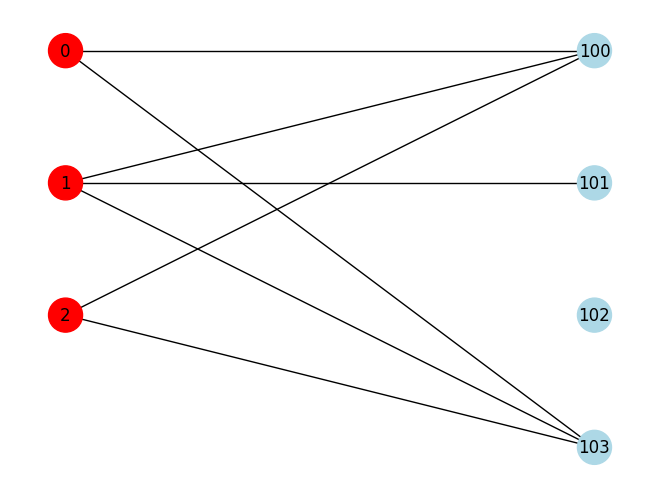

In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(seed=16)
np.set_printoptions(threshold=10000000)

B = nx.Graph()

user_num = 3
item_num = 4

user_nodes = [i for i in range(user_num)]
item_nodes = [i for i in range(100, 100 + item_num)]

B.add_nodes_from(user_nodes, bipartite=0)
B.add_nodes_from(item_nodes, bipartite=1)

node_color = []
node_size = [600 for i in range(user_num + item_num)]

for u in user_nodes:
    node_color.append("red")
for i in item_nodes:
    node_color.append("lightblue")

edge_nodes = []
pos = {}
for _i, u in enumerate(user_nodes):
    pos[u] = np.array([-1, -1.75 * _i])
    for _j, i in enumerate(item_nodes):
        pos[i] = np.array([1, -1.75 * _j])
        if np.random.random() < 0.45:
            edge_nodes.append((u, i))

B.add_edges_from(edge_nodes)

nx.draw(B, pos=pos, with_labels=True, node_color=node_color, node_size=node_size)

plt.show()

In [40]:
A = np.array(nx.adjacency_matrix(B).todense())
L = np.array(nx.laplacian_matrix(B).todense())
D = L + A

a2l.to_ltx(A, frmt="{:.0f}", arraytype="pmatrix")

\begin{pmatrix}
  0  &  0  &  0  &  1  &  0  &  0  &  1 \\
  0  &  0  &  0  &  1  &  1  &  0  &  1 \\
  0  &  0  &  0  &  1  &  0  &  0  &  1 \\
  1  &  1  &  1  &  0  &  0  &  0  &  0 \\
  0  &  1  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  1  &  1  &  1  &  0  &  0  &  0  &  0 
\end{pmatrix}


$$
\begin{pmatrix}
  0  &  0  &  0  &  1  &  0  &  0  &  1 \\
  0  &  0  &  0  &  1  &  1  &  0  &  1 \\
  0  &  0  &  0  &  1  &  0  &  0  &  1 \\
  1  &  1  &  1  &  0  &  0  &  0  &  0 \\
  0  &  1  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  1  &  1  &  1  &  0  &  0  &  0  &  0 
\end{pmatrix}
$$

In [30]:
a, v = np.linalg.eigh(A)

In [46]:
# 再現確認
_A = (v @ np.diagflat(a) @ v.T).round()
a2l.to_ltx(np.abs(_A), frmt="{:.0f}", arraytype="pmatrix")

\begin{pmatrix}
  0  &  0  &  0  &  1  &  0  &  0  &  1 \\
  0  &  0  &  0  &  1  &  1  &  0  &  1 \\
  0  &  0  &  0  &  1  &  0  &  0  &  1 \\
  1  &  1  &  1  &  0  &  0  &  0  &  0 \\
  0  &  1  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  1  &  1  &  1  &  0  &  0  &  0  &  0 
\end{pmatrix}


$$
\begin{pmatrix}
  -0.0 &  0.0 &  -0.0 &  1.0 &  -0.0 &  -0.0 &  1.0\\
  0.0 &  -0.0 &  -0.0 &  1.0 &  1.0 &  -0.0 &  1.0\\
  -0.0 &  -0.0 &  -0.0 &  1.0 &  -0.0 &  -0.0 &  1.0\\
  1.0 &  1.0 &  1.0 &  -0.0 &  0.0 &  -0.0 &  -0.0\\
  -0.0 &  1.0 &  -0.0 &  0.0 &  0.0 &  -0.0 &  0.0\\
  -0.0 &  -0.0 &  -0.0 &  -0.0 &  -0.0 &  -0.0 &  -0.0\\
  1.0 &  1.0 &  1.0 &  -0.0 &  0.0 &  -0.0 &  -0.0
\end{pmatrix}
$$

In [47]:
Q = 0
# スペクトル分解の再現性確認
for i in range(len(v)):
    Q += a[i] * v[:, i : i + 1] @ v[:, i : i + 1].T
np.abs(Q.round(2))

array([[0., 0., 0., 1., 0., 0., 1.],
       [0., 0., 0., 1., 1., 0., 1.],
       [0., 0., 0., 1., 0., 0., 1.],
       [1., 1., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 0., 0., 0., 0.]])

## 結論